# <center>Исследование рынка заведений общественного питания Москвы</center>

## Описание проекта  
Целью данной работы является проведение исследование текущего состояния сферы общественного питания Москвы. В ходе исследования будет определена перспективность открытия кафе, в котором в качестве официантов используются роботы. Результаты исследования будут представлены инвесторам в виде презентации.

## План выполнения работы:
 1. Подготовка данных к анализу;
 2. Анализ данных;
 3. Общие выводы и рекомендации;
 4. Презентация

## Часть 1. Подготовка данных к анализу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import itertools
import numpy as np

import requests
import json
from requests_toolbelt.utils import dump

# Уберем предупреждения, чтобы они не отвлекали от результатов работы
import warnings
warnings.filterwarnings("ignore")

# Разрешим выводить большое число строк
pd.set_option('display.max_rows',100)

### Изучение общей информации

In [2]:
# Загрузим данные о заведениях общественного питания Москвы
rest_data_df = pd.read_csv('datasets/rest_data.csv')
rest_data_df.name = 'rest_data'

# Чтобы содержимое колонок отображалось полностью, уберем лимит на ширину колонки
pd.set_option('display.max_colwidth', -1)

def display_df_info(df):
    """
    Функция выводит на экран основную информацию по датафрейму, а также его первые 10 строк.
    """
    print('===================')
    print('\033[1m' + df.name + '\033[0m')
    print('===================')
    display(df.info())
    display(df.describe())
    display(df.head(10))
    
display_df_info(rest_data_df)

rest_data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


None

id        number
count  15366.000000   15366.000000
mean   119720.066901  59.547182   
std    73036.130732   74.736833   
min    838.000000     0.000000    
25%    28524.000000   12.000000   
50%    144974.500000  40.000000   
75%    184262.250000  80.000000   
max    223439.000000  1700.000000

id               object_name chain object_type  \
0  151635  СМЕТАНА                   нет   кафе         
1  77874   Родник                    нет   кафе         
2  24309   Кафе «Академия»           нет   кафе         
3  21894   ПИЦЦЕТОРИЯ                да    кафе         
4  119365  Кафе «Вишневая метель»    нет   кафе         
5  27429   СТОЛ. ПРИ ГОУ СОШ № 1051  нет   столовая     
6  148815  Брусника                  да    кафе         
7  20957   Буфет МТУСИ               нет   столовая     
8  20958   КПФ СЕМЬЯ-1               нет   столовая     
9  28858   Столовая МТУСИ            нет   столовая     

                                               address  number  
0  город Москва, улица Егора Абакумова, дом 9           48      
1  город Москва, улица Талалихина, дом 2/1, корпус 1    35      
2  город Москва, Абельмановская улица, дом 6            95      
3  город Москва, Абрамцевская улица, дом 1              40      
4  город Москва, Абрамцевская улица, дом 9, корпус 1    50      
5  город Москва, Абрамцевская улица, дом 15, корпус 1   240     
6  город Москва, переулок Сивцев Вражек, дом 6/2        10      
7  город Москва, Авиамоторная улица, дом 8, строение 1  90      
8  город Москва, Авиамоторная улица, дом 8, строение 1  150     
9  город Москва, Авиамоторная улица, дом 8, строение 1  120

### Вывод:  
для анализа доступна таблица rest_data_df, содержащая 15366 строк информации и следующие столбцы:  
- object_name — название объекта общественного питания;  
- chain — сетевой ресторан;  
- object_type — тип объекта общественного питания;  
- address — адрес;  
- number — количество посадочных мест.  

Из общей информации о файле видно, что:  
- названия столбцов корректные, переименование не требуется;
- пропуски в таблице отсутствуют.
- в поле chain нужно заменить тип на boolean.

Далее проведем замену типа данных и проверку данных на наличие дубликатов и прочих ошибок.

### Замена типа данных

In [3]:
# Добавим столбец belongs_to_chain, содержащее булевые значения принадлежности к сети
rest_data_df['belongs_to_chain'] = rest_data_df['chain'] == 'да'
# Удалим ненужный больше столбец chain
rest_data_df = rest_data_df.drop(['chain'], axis=1)
display(rest_data_df.head())

id             object_name object_type  \
0  151635  СМЕТАНА                 кафе         
1  77874   Родник                  кафе         
2  24309   Кафе «Академия»         кафе         
3  21894   ПИЦЦЕТОРИЯ              кафе         
4  119365  Кафе «Вишневая метель»  кафе         

                                             address  number  belongs_to_chain  
0  город Москва, улица Егора Абакумова, дом 9         48      False             
1  город Москва, улица Талалихина, дом 2/1, корпус 1  35      False             
2  город Москва, Абельмановская улица, дом 6          95      False             
3  город Москва, Абрамцевская улица, дом 1            40      True              
4  город Москва, Абрамцевская улица, дом 9, корпус 1  50      False

### Поиск дубликатов и прочих ошибок

In [4]:
print('Всего строк в датафрейме: ' + str(rest_data_df.shape[0]))
# Проверим данные на наличие дубликатов
print('Количество полных дубликатов: ' + str(rest_data_df.duplicated().sum()))

# Проверим данные на наличие дубликатов без учета id и количичества посадочных мест, так как
# одно и то же заведение может быть записано под разными id и с разным числом посадочных мест
duplicatedRows = rest_data_df[rest_data_df[['object_name', 'object_type', 'address']].duplicated()]
print('Количество дубликатов без учета id: ' + str(duplicatedRows['id'].count()))
display(duplicatedRows.head(20).sort_values(by='object_name'))


Всего строк в датафрейме: 15366
Количество полных дубликатов: 0
Количество дубликатов без учета id: 171


id                                         object_name object_type  \
1409  151267  Альфорно                                            кафе         
3481  20914   Буфет Мади                                          буфет        
4042  27598   ГБОУ ШКОЛА №867 ОАО «Комбинат дошкольного питания»  столовая     
2565  23832   КАФЕ                                                кафе         
115   28614   КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА                буфет        
2384  28617   КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА                столовая     
2382  28615   КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА                столовая     
2383  28616   КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА                закусочная   
2380  28610   КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА                столовая     
2379  28609   КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА                буфет        
2375  28604   КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА                столовая     
2381  28611   КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА                столовая     
3747  28856   КП МЭИ                                              буфет        
581   149131  Общественное питание                                кафе         
580   149205  Общественное питание                                кафе         
4431  23759   СТОЛОВАЯ ГБОУ города Москвы № 384                   буфет        
4537  23391   Столовая «Комбинат питания КОСМОС»                  столовая     
2978  29209   Столовая при школе                                  столовая     
2398  20994   Фуршет.ру                                           буфет        
4462  26394   ЦЕНТР ПАВЛА СЛОБОДКИНА                              буфет        

                                                        address  number  \
1409  город Москва, город Зеленоград, корпус 438                 45       
3481  город Москва, Ленинградский проспект, дом 64               40       
4042  город Москва, улица Борисовские Пруды, дом 20, корпус 3    200      
2565  город Москва, улица Вавилова, дом 57, корпус 1             40       
115   город Москва, Бригадирский переулок, дом 3-5               12       
2384  город Москва, 2-я Бауманская улица, дом 5, строение 1      108      
2382  город Москва, 2-я Бауманская улица, дом 5, строение 1      168      
2383  город Москва, 2-я Бауманская улица, дом 5, строение 1      64       
2380  город Москва, 2-я Бауманская улица, дом 5, строение 1      200      
2379  город Москва, 2-я Бауманская улица, дом 5, строение 1      30       
2375  город Москва, 2-я Бауманская улица, дом 5, строение 1      150      
2381  город Москва, 2-я Бауманская улица, дом 5, строение 1      100      
3747  город Москва, Красноказарменная улица, дом 14, строение 1  160      
581   город Москва, Павелецкая площадь, дом 1                    39       
580   город Москва, Павелецкая площадь, дом 1                    35       
4431  город Москва, Беловежская улица, дом 67                    100      
4537  город Москва, Новозаводская улица, дом 12/11               15       
2978  город Москва, Флотская улица, дом 11                       150      
2398  город Москва, Гороховский переулок, дом 4                  10       
4462  город Москва, улица Арбат, дом 48, строение 1              55       

      belongs_to_chain  
1409  False             
3481  False             
4042  False             
2565  False             
115   False             
2384  False             
2382  False             
2383  False             
2380  False             
2379  False             
2375  False             
2381  False             
3747  False             
581   False             
580   False             
4431  False             
4537  False             
2978  False             
2398  False             
4462  False

Как видно, в данных присутствуют записи с одним и тем же названием, типом объекта и адресом, но разным id и количеством посадочных мест. Конечно, есть небольшая веростность, что в одном здании находятся 2 и более заведений одной сети с одинаковым названием, однако более вероятным видится, что это ошибка данных и от таких дубликатов следует избавиться.

In [5]:
# Удалим дубликаты (без учета id и number)
# Избавляемся от дубликатов
rest_data_df = \
rest_data_df.drop_duplicates(['object_name', 'object_type', 'address']).reset_index(drop = True)

print('Всего строк в датафрейме послед удаления дубликатов: ' + str(rest_data_df.shape[0]))

Всего строк в датафрейме послед удаления дубликатов: 15195


## Вывод

Первоначальная подготовка данных к анализу проведена. В случае появления необходимости, дополнительная подготовка будет проведена непосредственно во время выполнения анализа данных.

## Часть 2. Анализ данных

### Соотношение видов объектов общественного питания по количеству.

In [6]:
# Посчитаем колиечество заведений каждого типа
restCountByObjectType = rest_data_df.groupby('object_type').agg(
    id_count = pd.NamedAgg(column='id', aggfunc='count')).reset_index().sort_values(by='id_count', ascending=False)

display(restCountByObjectType)

# Отобразим количество объектов общественного питания каждого типа на столбчатой диаграмме
fig = px.bar(restCountByObjectType, x="object_type", y="id_count")
fig.update_layout(
    title="Количество объектов общественного питания по типу",
    title_x=0.5,
    xaxis_title="тип заведения",
    yaxis_title="количество"
)
fig.update_xaxes(tickangle=25)
fig.show()

# Отобразим соотношение видов объектов общественного питания по количеству на круговой диаграмме
fig = go.Figure(data=[go.Pie(labels=restCountByObjectType['object_type'], values=restCountByObjectType['id_count'])])
fig.update_layout(
    title="Соотношение типов объектов общественного питания по количеству",
    title_x=0.5,
)
fig.show()


object_type  id_count
3  кафе                               6017    
8  столовая                           2575    
7  ресторан                           2275    
6  предприятие быстрого обслуживания  1891    
0  бар                                853     
1  буфет                              571     
4  кафетерий                          393     
2  закусочная                         348     
5  магазин (отдел кулинарии)          272

### Вывод:  
Всего в Москве более 15000 заведений общественного питания. Подавляющее большинство из них(около 40%) относится к "кафе". На втором и третьем месте по количеству заведений находятся столовые (16.9%) и рестораны (14.9%).

###  Cоотношение сетевых и несетевых заведений по количеству.

In [7]:
# Посчитаем колиечество сетевых и несетевых заведений
restCountByBelongsToChain = rest_data_df.groupby('belongs_to_chain').agg(
    id_count = pd.NamedAgg(column='id', aggfunc='count')).reset_index()

restCountByBelongsToChain['belongs_to_chain'] = restCountByBelongsToChain['belongs_to_chain'].replace(True, 'сетевое')
restCountByBelongsToChain['belongs_to_chain'] = restCountByBelongsToChain['belongs_to_chain'].replace(False, 'не сетевое')

display(restCountByBelongsToChain.sort_values(by='id_count', ascending = False))

# Отобразим соотношение сетевых и несетевых заведений по количеству.
fig = go.Figure(data=[go.Pie(labels=restCountByBelongsToChain['belongs_to_chain'], \
                             values=restCountByBelongsToChain['id_count'])])
fig.update_layout(
    title="Соотношение сетевых и несетевых заведений по количеству",
    title_x=0.5,
)
fig.show()


belongs_to_chain  id_count
0  не сетевое       12245   
1  сетевое          2950

### Вывод:  
80% заведений Москвы не относятся к какой либо сети.

### Для какого вида объекта общественного питания характерно сетевое распространение.

In [8]:
# Выделим сетевые заведения в отдельгный датафрейм
chain_rest_df = rest_data_df[rest_data_df['belongs_to_chain'] == True]

# Посчитаем колиечество заведений каждого типа
restCountByObjectType_chain = chain_rest_df.groupby('object_type').agg(
    id_count = pd.NamedAgg(column='id', aggfunc='count')).reset_index().sort_values(by='id_count', ascending=False)

# соберем данные по количеству сетевых и не сетвых заведений в одном датафрейме
restCountByObjectType = restCountByObjectType.merge(
    restCountByObjectType_chain, left_on='object_type', right_on='object_type', \
    how='left', suffixes=['_all', '_chain'])

restCountByObjectType['chain_percentage'] = \
(restCountByObjectType['id_count_chain'] / restCountByObjectType['id_count_all'] * 100).round(1)

In [9]:
display(restCountByObjectType.sort_values(by='chain_percentage', ascending = False))

# Отобразим на столбчатой диаграмме процент сетевых заведений для объектов каждого типа
fig = px.bar(restCountByObjectType.sort_values(by='chain_percentage', ascending = False), \
             x="object_type", y="chain_percentage")
fig.update_layout(
    title="Процент сетевых заведений по типу",
    title_x=0.5,
    xaxis_title="тип заведения",
    yaxis_title="процент сетевых"
)
fig.update_xaxes(tickangle=25)
fig.show()


object_type  id_count_all  id_count_chain  \
3  предприятие быстрого обслуживания  1891          784              
8  магазин (отдел кулинарии)          272           78               
2  ресторан                           2275          541              
0  кафе                               6017          1389             
7  закусочная                         348           56               
6  кафетерий                          393           51               
4  бар                                853           37               
5  буфет                              571           11               
1  столовая                           2575          3                

   chain_percentage  
3  41.5              
8  28.7              
2  23.8              
0  23.1              
7  16.1              
6  13.0              
4  4.3               
5  1.9               
1  0.1

### Вывод:  
Сетевое распространение наиболее характерно для предприятий быстрого обслуживания: 41.5% таких объектов являются сетевыми. Высока доля сетевых заведений также среди кулинарий магазинов (28.6%), ресторанов (23.8%) и кафе (23%).

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест

#### Сформируем таблицу, содержащую информацию о сетях (название, число ресторанов, среднее число посадочных мест)

Для того, чтобы подсчитать количество заведений и среднее количество посадочных мест для каждой сети, необходимо вначале выделить названия сетей в отдельную колонку.

In [10]:
# Сгруппируем заведения по названию
chains = chain_rest_df.groupby('object_name').agg(
    rest_count = pd.NamedAgg(column='id', aggfunc='count')).reset_index()
print('Всего сетей (после простой группировки по названию): ' + str(chains['object_name'].count()))


Всего сетей (после простой группировки по названию): 723


Посмотрим, какие слова встречаются в названиях наиболее часто

In [11]:
# Получим массив названий
names = chains['object_name'].str.split().to_numpy()
# Объеденим все в один список
names = list(itertools.chain.from_iterable(names))
# Посчитаем, какое слово сколько раз встречается в названиях
words_in_names = pd.Series(names)
print(words_in_names.value_counts().head(20))

Кафе            85
Ресторан        47
Пицца           24
Суши            16
КАФЕ            15
быстрого        15
Кофе            14
Прайм           13
Предприятие     12
кафе            11
обслуживания    11
Пиццерия        10
Хинкальная      10
стар            10
Закусочная      10
KFC             9 
Кофейня         9 
и               8 
№1              8 
Бургер          8 
dtype: int64


Обработаем названия для формирования названия сети:  
- Приведем к нижнему регистру;
- Удалим из названий лишние слова: ['кафе', 'ресторан', 'пиццерия', 'предприятие быстрого обслуживания', 'закусочная', 'кофейня', 'бар', 'азс'];
- Удалим из названий кавычки.

И сохраним полученные значения в колонку chain_name.

In [12]:
# Приведем названия заведений к нижнему регистру
chain_rest_df['object_name'] = chain_rest_df['object_name'].str.lower()

# заменим название сети'starbucks' на "старбакс"
chain_rest_df['object_name'] = chain_rest_df['object_name'].str.replace('starbucks', 'старбакс')

# Удалим лишние слова и сохраним полученное название в качестве названия сети
def remove_extra_words(row):
    words_to_remove = ['кафе', 'ресторан', 'пиццерия', 'предприятие', 'быстрого', \
                       'обслуживания', 'закусочная', 'кофейня', 'бар', 'азс', 'кулинарная', 'лавка']
    new_name = ""
    if isinstance(row['object_name'], str):
        old_name_words = row['object_name'].split()
        name_array = []
        for word in old_name_words:
            if word not in words_to_remove:
                name_array.append(word)
        new_name = " ".join(name_array)
    else:
        new_name = row['object_name']
    return new_name

chain_rest_df['chain_name'] = chain_rest_df.apply(remove_extra_words, axis=1)

# Уберем из названия сети кавычки
chain_rest_df['chain_name'] = chain_rest_df['chain_name'].str.replace('«', '')
chain_rest_df['chain_name'] = chain_rest_df['chain_name'].str.replace('»', '')


#### Сгруппируем заведения по названию сети, посчитаем количество ресторанов и среднее число посадочных мест.   
Не смотря на то, что по числу посадочных мест в данных присутствует сильный разброс и даже выбросы (это было установлено в процессе изучения результатов выполнения команды info в шаге №1), в качестве меры центральной тенденции применим среднее, так как в рамках каждой отдельной сети выбросы скорее всего отсутствуют. 

In [13]:
# Пересоздадим переменную chain
chains = chain_rest_df.groupby('chain_name').agg(
    rest_count = pd.NamedAgg(column='id', aggfunc='count'),
    mean_seat_number = pd.NamedAgg(column='number', aggfunc='mean')
).reset_index().round(1)

print('Всего сетей: ' + str(chains['chain_name'].count()))

display(chains.sort_values(by='rest_count', ascending=False).head())

Всего сетей: 435


chain_name  rest_count  mean_seat_number
420  шоколадница  180         58.1            
25   kfc          174         55.1            
233  макдоналдс   168         88.2            
104  бургер кинг  150         46.5            
375  теремок      108         26.8

#### Отобразим количество ресторанов и среднее число посадочных мест для каждой сети на графике

In [14]:
# Отобразим количество ресторанов и среднее число посадочных мест для каждой сети на графике
fig = px.scatter(chains, \
             x="mean_seat_number", y="rest_count", width=900, height=600)
fig.update_layout(
    title="Количество ресторанов и среднее число посадочных мест для каждой сети",
    title_x=0.5,
    xaxis_title="среднее число посадочных мест",
    yaxis=dict(title='количество ресторанов', dtick=25)
)
fig.show()

Как видно, часть сетей в своих заведениях вообще не имеет посадочных мест. Посмотрим, что это за сети.

In [15]:
display(chains[chains['mean_seat_number'] < 1].sort_values(by='rest_count', ascending=False).head())

chain_name  rest_count  mean_seat_number
198  кофе с собой                     43          0.8             
293  пицца паоло                      17          0.8             
350  стардогs                         15          0.7             
227  магазин готовой еды милти        3           0.0             
385  точка продажи готовой еды милти  2           0.0

Как видно, сети со средним количеством посадочных мест меньше 1 (то есть имеющие в своем составе много заведений вообще без посадочных мест) являются точками быстрого питания (ларьки с кофе, пицца навынос, точки продажи хотдогов) либо местами продажи готовой еды. Таким образом можно сделать вывод, что количество посадочных мест, равное нолю, не является ошибкой в данных.

### Вывод

Как следует из графика, для большинства сетей в Москве характерно небольшое число ресторанов (до 10) с небольшим числом посадочных мест (до 50). Также значительное число сетей имеет небольшое число ресторанов (до 10), и среднее число посадочных мест (от 50 до 100).  
Сетей с большим числом ресторанов при малом числе посадочных мест и с большим числом посадочных мест при малом числе ресторанов в Москве мало.  
Также часть сетей не имеет посадочных мест. Скорее всего, это заведения, работающие только на вынос (например шаурмичные, ларьки и кофе, точки продажи готовой еды).

### Cреднее количество посадочных мест для каждого вида объекта общественного питания

Для начала определим как распределено количество посадочных мест в заведениях вне зависимости от типа заведения. Также посмотрим, присутствуют ли выбросы, которые могут повлиять на рассчет среднего. 

In [16]:
fig = px.histogram(rest_data_df, \
             x="number", width=900, height=600)
fig.update_layout(
    title="Общее распределение количество посадочных мест (вне зависимости от типа заведения)",
    title_x=0.5,
    xaxis_title="среднее число посадочных мест",
    yaxis_title="количество ресторанов"
)
fig.show()

В данных присутствуют заведения с очень большим числом посадочных мест (более 600). Несмотря на то, что таких заведений очень мало, такое большое количество посадочных мест может привести к искажению среднего. Также в данных присутствует много заведений, не исеющих посадочных мест. Скорее всего, это не является ошибкой, просто данные заведения работают только на вынос (например шаурмичные и ларьки с кофе).  
**В связи с вышесказанным, видится целесообразным в качестве меры центральной тенденции применить медиану**.

In [17]:
meanSeatNumberByType = rest_data_df.groupby('object_type')['number'].median().reset_index()
print('Cреднее количество посадочных мест для каждого вида объекта общественного питания:')
display(meanSeatNumberByType.sort_values(by='number'))

Cреднее количество посадочных мест для каждого вида объекта общественного питания:


object_type  number
2  закусочная                         0     
5  магазин (отдел кулинарии)          0     
4  кафетерий                          6     
6  предприятие быстрого обслуживания  6     
1  буфет                              32    
3  кафе                               32    
0  бар                                35    
7  ресторан                           80    
8  столовая                           103

In [18]:
# Отобразим на столбчатой диаграмме cреднее количество посадочных мест для каждого вида объекта
fig = px.bar(meanSeatNumberByType.sort_values(by='number', ascending = False), \
             x="object_type", y="number")
fig.update_layout(
    title="Cреднее количество посадочных мест по типу заведения",
    title_x=0.5,
    xaxis_title="тип заведения",
    yaxis=dict(title='Cреднее число посадочных мест', dtick=10)
)
fig.update_xaxes(tickangle=25)
fig.show()

### Вывод

В среднем, самое большое количество посадочных мест предоставляют столовые (103 места) и рестораны (80 мест). Практически одинаковое среднее количество посадочных мест (от 32х до 35ти) характерно для баров, буфетов и кафе. Кафетерии и предприятия быстрого обслуживания в среднем имеют по 6 посадочных мест, а закусочные и отделы кулинарии работают в основном навынос и посадочных мест не предоставляют.

### Топ-10 улиц по количеству объектов общественного питания

#### Выделим информацию об улице в отдельный столбец.

In [19]:
# Поскольку формат адреса во всех строках одинаковый, разобем адрес на список по запятым и выберем первый элемент
rest_data_df['street'] = rest_data_df.apply(
    lambda x: x['address'].split(', ')[1], axis = 1
)
display(rest_data_df.head())

id             object_name object_type  \
0  151635  СМЕТАНА                 кафе         
1  77874   Родник                  кафе         
2  24309   Кафе «Академия»         кафе         
3  21894   ПИЦЦЕТОРИЯ              кафе         
4  119365  Кафе «Вишневая метель»  кафе         

                                             address  number  \
0  город Москва, улица Егора Абакумова, дом 9         48       
1  город Москва, улица Талалихина, дом 2/1, корпус 1  35       
2  город Москва, Абельмановская улица, дом 6          95       
3  город Москва, Абрамцевская улица, дом 1            40       
4  город Москва, Абрамцевская улица, дом 9, корпус 1  50       

   belongs_to_chain                 street  
0  False             улица Егора Абакумова  
1  False             улица Талалихина       
2  False             Абельмановская улица   
3  True              Абрамцевская улица     
4  False             Абрамцевская улица

In [20]:
# Посчитаем количество объектов общественного питания на каждой улице
restCountByStreet = rest_data_df.groupby('street').agg(
    numberOfRestaurants = pd.NamedAgg(column='id', aggfunc='count')
).reset_index()

display(restCountByStreet.sort_values(by='numberOfRestaurants', ascending=False).head(10))

street  numberOfRestaurants
1334  город Зеленоград        230                
1452  проспект Мира           197                
993   Профсоюзная улица       180                
683   Ленинградский проспект  170                
979   Пресненская набережная  165                
407   Варшавское шоссе        160                
686   Ленинский проспект      147                
1419  поселение Сосенское     137                
1449  проспект Вернадского    127                
674   Кутузовский проспект    114

In [21]:
display(rest_data_df[rest_data_df['street'] == 'город Зеленоград'].head())
display(rest_data_df[rest_data_df['street'] == 'поселение Сосенское'].head())

id               object_name object_type  \
1383  22331  СТОЛОВАЯ МИЭТ             столовая     
1402  20199  ЭТО                       кафе         
1403  68113  Френдс                    кафе         
1404  20105  Кафе «Граф Монте-Кристо»  кафе         
1405  22982  Альфорно                  кафе         

                                                   address  number  \
1383  город Москва, город Зеленоград, улица Юности, дом 11  56       
1402  город Москва, город Зеленоград, корпус 401            35       
1403  город Москва, город Зеленоград, корпус 435            34       
1404  город Москва, город Зеленоград, корпус 436            40       
1405  город Москва, город Зеленоград, корпус 438            49       

      belongs_to_chain            street  
1383  False             город Зеленоград  
1402  False             город Зеленоград  
1403  False             город Зеленоград  
1404  False             город Зеленоград  
1405  False             город Зеленоград

id                  object_name object_type  \
1880  149758  Поесть и поиграть            кафе         
1881  149891  Пивбар у бобра               бар          
1882  147991  Кафе пекарня Есть поесть     кафе         
1883  155496  Кафе-пиццерия суши           кафе         
1885  138697  Ресторанный дом Flash Royal  ресторан     

                                                                                         address  \
1880  город Москва, поселение Сосенское, посёлок Коммунарка, улица Липовый Парк, дом 5, корпус 1   
1881  город Москва, поселение Сосенское, посёлок Коммунарка, улица Липовый Парк, дом 5, корпус 1   
1882  город Москва, поселение Сосенское, посёлок Коммунарка, улица Липовый Парк, дом 5, корпус 1   
1883  город Москва, поселение Сосенское, посёлок Коммунарка, улица Сосенский Стан, дом 11          
1885  город Москва, поселение Сосенское, улица Александры Монаховой, дом 101                       

      number  belongs_to_chain               street  
1880  20      False             поселение Сосенское  
1881  20      False             поселение Сосенское  
1882  15      False             поселение Сосенское  
1883  16      False             поселение Сосенское  
1885  190     False             поселение Сосенское

Среди названий улиц присутствует 'город Зеленоград' и 'поселение Сосенское'. При формировании списка улиц с наибольшим числом заведений, исключим записи для 'город Зеленоград' и 'поселение Сосенское'.

In [22]:
# Посчитаем количество объектов общественного питания на каждой улице, исключив 'город Зеленоград' и 'поселение Сосенское'
restCountByStreet = rest_data_df[~rest_data_df['street'].isin(['город Зеленоград', 'поселение Сосенское'])]\
.groupby('street').agg(
    numberOfRestaurants = pd.NamedAgg(column='id', aggfunc='count')
).reset_index()

# Сохраним названия ТОП-10 улиц в список
top10streets = restCountByStreet.sort_values(by='numberOfRestaurants', ascending=False).head(10)['street'].tolist()

# Отобразим улицы в порядке убывания числа заведений
display(restCountByStreet.sort_values(by='numberOfRestaurants', ascending=False).head(10))

street  numberOfRestaurants
1450  проспект Мира           197                
993   Профсоюзная улица       180                
683   Ленинградский проспект  170                
979   Пресненская набережная  165                
407   Варшавское шоссе        160                
686   Ленинский проспект      147                
1447  проспект Вернадского    127                
674   Кутузовский проспект    114                
600   Каширское шоссе         110                
605   Кировоградская улица    107

In [23]:
# Отобразим на столбчатой диаграмме количество заведений на ТОП-10 улицах
fig = px.bar(restCountByStreet.sort_values(by='numberOfRestaurants', ascending=False).head(10), \
             x="street", y="numberOfRestaurants")
fig.update_layout(
    title="Количество заведений по ТОП-10 улицам",
    title_x=0.5,
    xaxis_title="Улица",
    yaxis=dict(title='Количество заведений', dtick=25)
)
fig.update_xaxes(tickangle=25)
fig.show()

#### Узнаем в каких районах находятся улицы из TOP-10

Для того, чтобы узнать, в каких районах находятся указанные улицы, нужно сперва узнать, в каких районах находятся, расположенные на них заведения.  
Чтобы получить информацию о районе расположения каждого из заведений, было использовано API Геокодера от Yandex. Полученные данные о координатах заведения и о районе расположения были сохранены в отдельный CSV файл на google spreadsheets. Данный csv файл и был в дальнейшем использован в проекте.  
Ниже приведен код, с помощью которого был сформирован CSV файл, содержищий координаты и названия районов.

#### Выгрузим созданный файл из google spreadsheets

In [24]:
from io import BytesIO
spreadsheet_id = '1KJ3cifd1dYVcPxoG4VCaFX8bjuiXH5Z1SoGmOLxu5sA'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
rests_full_df = pd.read_csv(BytesIO(r.content))

display(rests_full_df.head())


id             object_name object_type  \
0  151635  СМЕТАНА                 кафе         
1  77874   Родник                  кафе         
2  24309   Кафе «Академия»         кафе         
3  21894   ПИЦЦЕТОРИЯ              кафе         
4  119365  Кафе «Вишневая метель»  кафе         

                                             address  number  \
0  город Москва, улица Егора Абакумова, дом 9         48       
1  город Москва, улица Талалихина, дом 2/1, корпус 1  35       
2  город Москва, Абельмановская улица, дом 6          95       
3  город Москва, Абрамцевская улица, дом 1            40       
4  город Москва, Абрамцевская улица, дом 9, корпус 1  50       

   belongs_to_chain                 street          coordinates  \
0  False             улица Егора Абакумова  37.714474 55.879005   
1  False             улица Талалихина       37.673295 55.738307   
2  False             Абельмановская улица   37.669576 55.735571   
3  True              Абрамцевская улица     37.573007 55.892713   
4  False             Абрамцевская улица     37.572279 55.904074   

            district  
0  Ярославский район  
1  Таганский район    
2  Таганский район    
3  район Лианозово    
4  район Лианозово

In [25]:
# Проверим, для всех ли строк заполнились данные по координатом и району
print('Данные по координатам или району не заполнены для {} строк'\
      .format(rests_full_df[(rests_full_df['coordinates'].isnull()) | \
                               (rests_full_df['district'].isnull())].shape[0]))

Данные по координатам или району не заполнены для 139 строк


In [26]:
# Удалим строки, где не заполнены данные по координатам или району
rests_full_df = rests_full_df.dropna()

#### Узнаем, в каких районах находятся улицы из ТОП-10

In [27]:
# Создадим датафрейм, в который сохраним информацию только о заведениях, находящихся на топ-10 улицах
top10_streets_rests_df = rests_full_df[rests_full_df['street'].isin(top10streets)]

# Сгруппируем данные по улице и району
restCountByTopStreets = top10_streets_rests_df.groupby(['street','district']).agg(
    numberOfRestaurants = pd.NamedAgg(column='id', aggfunc='count')
)

display(restCountByTopStreets.sort_values(by=['street','numberOfRestaurants'], ascending=False))

numberOfRestaurants
street                 district                                                               
проспект Мира          Мещанский район                                     63                 
                       район Свиблово                                      56                 
                       Алексеевский район                                  50                 
                       Останкинский район                                  19                 
                       район Ростокино                                     5                  
                       жилой комплекс Триколор                             2                  
                       Ярославский район                                   1                  
                       жилой комплекс Хилл8                                1                  
проспект Вернадского   район Тропарёво-Никулино                            61                 
                       район Раменки                                       31                 
                       район Проспект Вернадского                          16                 
                       Ломоносовский район                                 14                 
                       жилой комплекс Миракс Парк                          2                  
                       Гагаринский район                                   1                  
                       микрорайон Ленинские Горы                           1                  
Профсоюзная улица      1-4-й микрорайон                                    39                 
                       Обручевский район                                   32                 
                       район Черёмушки                                     27                 
                       Академический район                                 25                 
                       48-50-й квартал                                     16                 
                       район Ясенево                                       14                 
                       44-47-й квартал района Коньково                     9                  
                       Новые Черёмушки квартал 22-23                       8                  
                       7-9-й микрорайон                                    5                  
                       1-й микрорайон                                      1                  
                       2-й микрорайон                                      1                  
                       3-4-й микрорайон района Коньково                    1                  
                       4-5-й микрорайон                                    1                  
                       41-й квартал района Коньково                        1                  
Пресненская набережная Московский международный деловой центр Москва-Сити  165                
Ленинский проспект     Гагаринский район                                   39                 
                       37-й квартал                                        24                 
                       район Якиманка                                      24                 
                       район Тропарёво-Никулино                            20                 
                       Донской район                                       15                 
                       Ломоносовский район                                 7                  
                       Обручевский район                                   7                  
                       16-й квартал                                        5                  
                       9-й микрорайон                                      3                  
                       район Проспект Вернадского                          2                  
                       жилой комплекс Велл Хаус                            1         

Как видно из полученной группировки, большинство улиц из Топ-10 проходят через несколько районов.   
Исключение составляет Пресненская набережная, которая расположена в единственном районе Москва-Сити.

Отобразим на карте заведения, расположенные на Топ-10 улицах

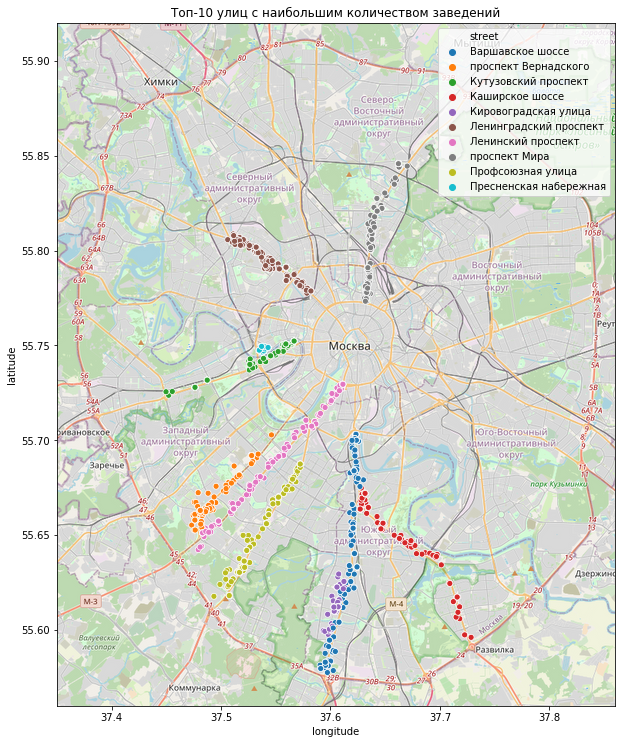

In [28]:
# Разделим данные в coordinates на долготу (longitude) и широту (latitude)
top10_streets_rests_df['coordinates'] = top10_streets_rests_df['coordinates'].str.split(' ')
top10_streets_rests_df['longitude'] = top10_streets_rests_df['coordinates'].map(lambda x: x[0]).astype(float)
top10_streets_rests_df['latitude'] = top10_streets_rests_df['coordinates'].map(lambda x: x[1]).astype(float)

# Зададим границы области карты
BBox = (37.350000, 37.860000, 55.560000, 55.920000)

# Выгрузим png файл с картой Москвы
ruh_m = plt.imread('https://drive.google.com/uc?export=download&id=1yAgV_uXAOwFjFgADmFWWwjHQMF86remW')

# Отобразим каждый ресторан на scatterplot.
# Для этого по оси x отложим долготу, а по оси y широту
fig, ax = plt.subplots(figsize = (10,12.56))
sns.scatterplot(data=top10_streets_rests_df, x='longitude', y='latitude', hue='street')
ax.set_title('Топ-10 улиц с наибольшим количеством заведений')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

# Подложим под scatterplot изображение карты Москвы
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'auto', interpolation='lanczos')
plt.show()

Улицы, входящие в ТОП-10 по числу заведений расположены между Садовым кольцом и МКАД. Большинство из этих улиц очень длинные и, как уже было сказано ранее, пересекает множество районов. Это вполне ожидаемый результат, который является следствием постановки задачи по определению Топ-10 улиц: если рассматривать абсолютное число заведений, то на самых длинных улицах (проходящих через множество районов) их наверняка будет больше всего.  
Как и по количеству районов, по протяженности исключением является Пресненская набережная. Данная улица имеет большое количество  заведений общественного питания (165) при относительно небольшой протяженности. Соответственно, концентрация заведений на данной улице наибольшая из ТОП-10.

In [29]:
# Сгруппируем по району все заведения (вне зависимости от улицы)
restCountByTopDistricts_full = rests_full_df.groupby(['district']).agg(
    numberOfRestaurants = pd.NamedAgg(column='id', aggfunc='count')
)

display(restCountByTopDistricts_full.sort_values(by=['numberOfRestaurants'], ascending=False).head(10))

numberOfRestaurants
district                                                               
Тверской район                                      773                
Басманный район                                     615                
Пресненский район                                   465                
Даниловский район                                   402                
район Замоскворечье                                 385                
Таганский район                                     354                
Мещанский район                                     344                
Красносельский район                                225                
Московский международный деловой центр Москва-Сити  193                
район Якиманка                                      190

Больше всего заведений в Тверском (773 заведения), Басманном (615) и Пресненском (465) районах.

In [30]:
# Сгруппируем по району заведения, расположенные на ТОП-10 улицах.
restCountByTopDistricts = top10_streets_rests_df.groupby(['district']).agg(
    numberOfRestaurants = pd.NamedAgg(column='id', aggfunc='count')
)

display(restCountByTopDistricts.sort_values(by=['numberOfRestaurants'], ascending=False).head(10))

numberOfRestaurants
district                                                               
Московский международный деловой центр Москва-Сити  165                
район Чертаново Центральное                         89                 
район Тропарёво-Никулино                            81                 
Мещанский район                                     63                 
район Аэропорт                                      61                 
район Дорогомилово                                  61                 
район Свиблово                                      56                 
район Нагатино-Садовники                            55                 
район Фили-Давыдково                                53                 
Алексеевский район                                  50

Наибольшее число заведений расположено в районе Москва-Сити (165), Чертаново Центральное (89) и Тропарёво-Никулино (81).

### Вывод:

Наибольшее число объектов общественного питания расположено на протяженных улицах, таких как проспект Мира (197 заведений), Профсоюзная улица (180 заведений), Ленинградский проспект (170 заведений). Данные улицы расположены между Садовым кольцом и МКАД и проходят через множество районов. Исключение составляет Пресненская набережная, которая расположена в единственном районе (Москва-Сити). Данная улица имеет большое число заведений (165) при малой протяженности. Соответственно, концентрация заведений на данной улице наибольшая из ТОП-10.  
Наибольшее число заведений, находящихся на ТОП-10 улиц, расположено в районе Москва-Сити, Чертаново Центральное и Тропарёво-Никулино.
Однако, если рассматривать число заведений без привязки к улицам, то больше всего заведений расположено в центральных районах Москвы: Тверском, Басманном, Пресненском.

### Улицы с одним заведением

In [31]:
# Посчитаем количество улиц с одним объектом общественного питания
print("Улиц с одним объектом общественного питания: {}"\
      .format(restCountByStreet[restCountByStreet['numberOfRestaurants'] == 1].shape[0]))

# Сохраним названия улиц с одним объектом общественного питания в список
streetsWith1Rest = restCountByStreet[restCountByStreet['numberOfRestaurants'] == 1]['street'].tolist()

# Создадим датафрейм, в который сохраним информацию только о заведениях, находящихся на улицах с одним заведением
empty_streets_rests_df = rests_full_df[rests_full_df['street'].isin(streetsWith1Rest)]


Улиц с одним объектом общественного питания: 579


In [32]:
# Сгруппируем улицы с одним заведением по району
empty_streets_by_district = empty_streets_rests_df.groupby('district').agg(
    numberOfRestaurants = pd.NamedAgg(column='street', aggfunc='count')
)

display(empty_streets_by_district.sort_values(by='numberOfRestaurants', ascending=False).head(10))

numberOfRestaurants
district                                 
Таганский район       31                 
Тверской район        21                 
Басманный район       20                 
Пресненский район     18                 
район Марьина Роща    17                 
Мещанский район       14                 
район Сокольники      14                 
район Замоскворечье   12                 
район Якиманка        11                 
район Соколиная Гора  11

Отобразим на карте заведения, которые являются единственными на своих улицах

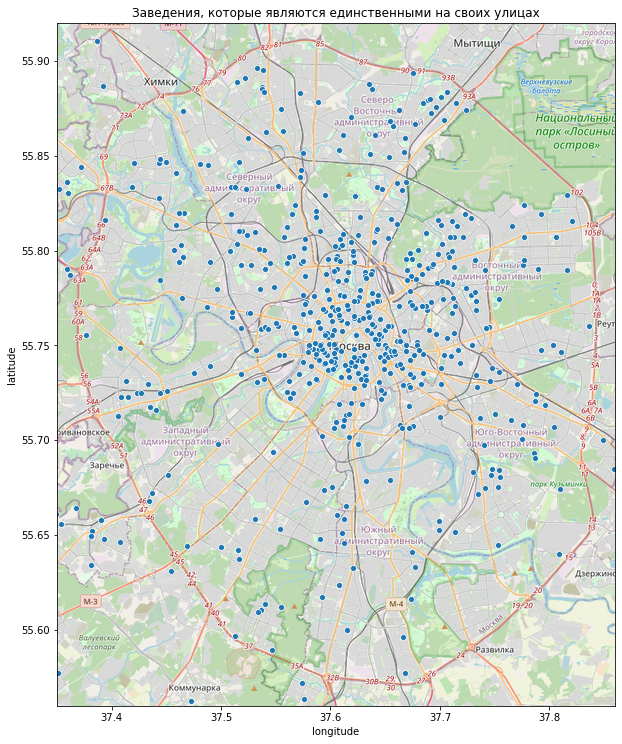

In [33]:
# Разделим данные в coordinates на долготу (longitude) и широту (latitude)
empty_streets_rests_df['coordinates'] = empty_streets_rests_df['coordinates'].str.split(' ')
empty_streets_rests_df['longitude'] = empty_streets_rests_df['coordinates'].map(lambda x: x[0]).astype(float)
empty_streets_rests_df['latitude'] = empty_streets_rests_df['coordinates'].map(lambda x: x[1]).astype(float)


# Зададим границы области карты
BBox = (37.350000, 37.860000, 55.560000, 55.920000)

# Выгрузим png файл с картой Москвы
ruh_m = plt.imread('https://drive.google.com/uc?export=download&id=1yAgV_uXAOwFjFgADmFWWwjHQMF86remW')

# Отобразим каждый ресторан на scatterplot.
# Для этого по оси x отложим долготу, а по оси y широту
fig, ax = plt.subplots(figsize = (10, 12.56))
sns.scatterplot(data=empty_streets_rests_df, x='longitude', y='latitude')
ax.set_title('Заведения, которые являются единственными на своих улицах')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

# Подложим под scatterplot изображение карты Москвы
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'auto', interpolation='lanczos')
plt.show()

### Вывод

Наибольшая концентрация улиц с одним заведением наблюдается в центре Москвы (внутри Садового кольца). Больше всего таких улиц в Таганском (31 улица), Тверском (21 улица) и Басманном (20 улиц) районах. Чем ближе к МКАД, тем меньше становится улиц с одним заведением общественного питания.  
Такая закономерность возможно объясняется большим числом мелких улиц в центре Москвы.

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

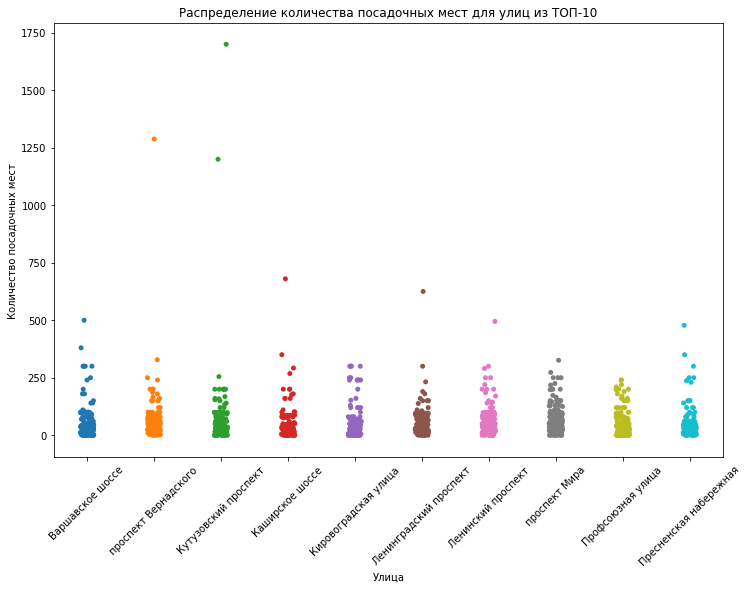

In [34]:
# Оценим распределение количества посадочных мест для каждой улицы из ТОП-10
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (12, 8))
sns.stripplot(x="street", y="number", data=top10_streets_rests_df)
ax.set_title('Распределение количества посадочных мест для улиц из ТОП-10')
ax.set_xlabel('Улица')
ax.set_ylabel('Количество посадочных мест')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()


Как видно, достаточно большая часть заведений не имеет посадочных мест (работает навынос). Также в данных присутствует небольшое число заведений с аномально большим числом посадочных мест.  
Оценим общее распределение посадочных мест без учета заведений с аномально большим их количеством.

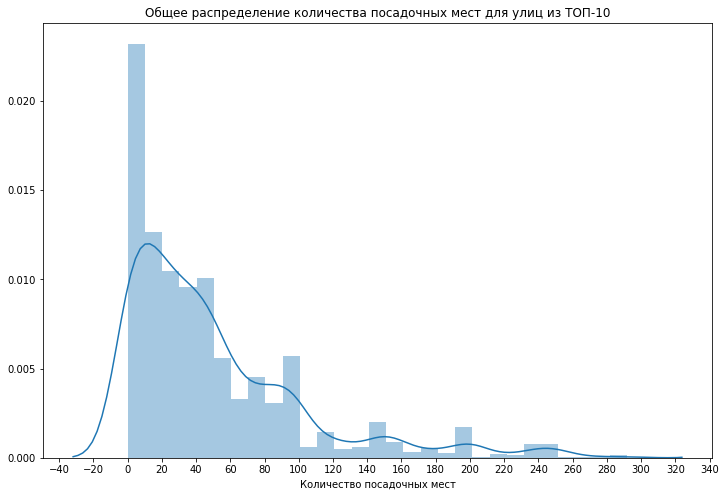

In [35]:
# Отобразим общее распределение количества посадочных мест без учета ресторанов с аномально большим числом посадочных мест
fig, ax = plt.subplots(figsize = (12, 8))
sns.distplot(top10_streets_rests_df[top10_streets_rests_df['number'] < 300]['number'])
ax.set_title('Общее распределение количества посадочных мест для улиц из ТОП-10')
ax.set_xlabel('Количество посадочных мест')
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.show()

Как видно, по количеству посадочных мест заведения можно условно разделить на несколько групп:  
- не имеют посадочных мест (работают навынос);
- от 1 до 49 посадочных мест;
- от 50 до 99 посадочных мест;
- от 100 до 299 посадочных мест;
- более 300 посадных мест.

Добавим данные категории в таблицу с заведениями и отобразим заведения на карте.

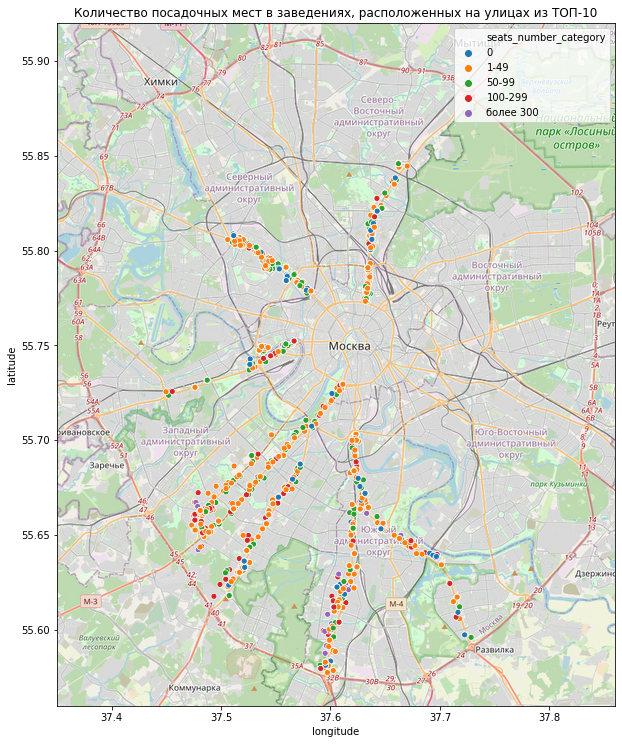

In [36]:
# Добавим информацию о категории заведения по количеству мест
def set_seats_number_category(row):
    if row['number'] == 0:
        category = '0'
    elif (1 <= row['number'] <= 49):
        category = '1-49'
    elif (50 <= row['number'] <= 99):
        category = '50-99'
    elif (100 <= row['number'] <= 299):
        category = '100-299'
    else : category = 'более 300'
    return category

top10_streets_rests_df['seats_number_category'] = top10_streets_rests_df.apply(set_seats_number_category, axis=1)

# Отобразим каждый ресторан на scatterplot. Цветом обозначим категорию числа посадочных мест
fig, ax = plt.subplots(figsize = (10, 12.56))
sns.scatterplot(data=top10_streets_rests_df, \
                x='longitude', y='latitude', hue = 'seats_number_category', \
                hue_order = ['0', '1-49', '50-99', '100-299', 'более 300'])
ax.set_title('Количество посадочных мест в заведениях, расположенных на улицах из ТОП-10')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

# Подложим под scatterplot изображение карты Москвы
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'auto', interpolation='lanczos')
plt.show()

### Вывод

Большинство заведений, расположенных на улицах из ТОП-10, имеет менее 50 посадочных мест. Причем достаточно большая часть заведений не имеет посадочных мест вовсе (работает навынос).  
С ростом числа посадочных мест, количество  заведений уменьшается. Также наблюдаются небольшие пики количества заведений с числом посадочных мест около 100, 150, 200 и 250. То есть заведения часто имеют количество мест кратное 50. Возможно, это связано с различными санитарными требованиями, предъявляемыми к заведениям в зависимости от числа посадочных мест (согласно санитарным нормативным актам, величина предприятий общественного питания характеризуется количеством мест в обеденных залах). Однако проверка этой гипотезы не является частью данной работы.  
На крупных улицах также присутствуют заведения с аномально большим числом посадочных мест (от 300 до 1750), однако такие заведения единичны.

## Часть 3. Общие выводы и рекомендации

### Текущее состояние сферы общественного питания Москвы

Всего в Москве насчитывается более 15 000 заведений общественного питания. Около 40% из них составляют кафе.  
Подавляющее число заведений (80%) не относится к какой либо сети. Наибольшая доля сетевых заведений наблюдается среди предприятий быстрого обслуживания (более 40% таких заведений являются сетевыми). Среди ресторанов и кафе доля сетевых заведений не превышает 25%. Среди сетей преобладают малые: небольшое число заведений (до 10) с небольшим числом посадочных мест (до 50).  
Первые места по количеству заведений общественного питания ожидаемо занимают протяженные улицы, проходящие через множество районов Москвы: проспект Мира, Профсоюзная улица, Ленинградский проспект. В то же время наибольшая концентрация заведений наблюдается на Пресненской набережной, которая расположена в единственном районе Москва-Сити.  
Если рассматривать число заведений без привязки к улицам, то больше всего заведений расположено в центральных районах Москвы: Тверском, Басманном, Пресненском.
Большинство заведений, расположенных на улицах с большим количеством объектов общественного питания имеет менее 50 посадочных мест. Причем достаточно большая часть заведений не имеет посадочных мест вовсе (работает навынос).  
Вместе с тем, в Москве достаточно много улиц, на которых расположено всего одно заведение. Наибольшая концентрация таких улиц наблюдается в центре Москвы (внутри Садового кольца).  

### Рекомендации об открытии нового заведения

В связи с вышеизложенным наиболее перспективным видится открытие заведения общественного питания, соответствующего следующим критериям:  

**Тип заведения:** кафе. Данный тип заведения является наиболее популярным среди москвичей, а также имеет достаточно свободный формат, чтобы в рамках него можно было рализовать идею с роботами-официантами;  

**Количество посадочных мест:** до 50. Такое число посадочных мест является наиболее распространенным среди кафе Москвы. Также небольшое число посадочных мест позволит разместить кафе в более популярных (но дорогих) районах Москвы и применять к нему менее строгие критерии контрольных служб.  

**Район расположения.** В связи с тем, что проект планируется необычный и дорогостоящий, для размещения кафе целесообразно рассматривать популярные места. Вместе с тем, центтальные районы москвы, такие как Тверской, Басманный, Пресненский и так имеют очень много заведений. Наиболее подходящим видится район Дорогомилово. Преимуществами данного района являются:  
- расположен вблизи центра Москвы (граничит с популярным Арбатом);
- граничит с Москва-Сити: деловой центр может служить хорошим источником посетителей, которым будет интересна прогрессивная идея обслуживания роботами;  
- через него проходит Кутузовский проспект, являющийся одной из важнейших транспортных магистралей Москвы;
- не имеет такого большого количества заведений, как наиболее популярные районы (например Тверской, Басманный и Пресненский). Следствием может являться меньшая конкуренция и, возможно, меньшая стоимость аренды.  

**Развитие сети.** В связи с необычностью идеи (обслуживание клиентов роботами), дороговизной ее реализаци, а также общей тенденцией преобладания среди сетевых заведений небольших предприятий быстрого обслуживания, в настоящее время развитие сети видится нецелесообразным.

## Презентация для инвесторов

Презентация: <https://drive.google.com/file/d/10H3G-GMwrOYsH4qNIm9C-K5ceKZi6zdQ/view>